In [1]:
from datetime import datetime
from tensorflow.keras import layers, Model, Input, regularizers
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

import imgaug
import imgaug.augmenters as iaa
import random
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from livelossplot import PlotLossesKerasTF
import cv2
import pandas as pd


Vamos a tratar de usar un [conjunto de imagenes etiquetadas para detección de géneros](https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset) con el objetivo de reconocer expresiones faciales. Como el dataset no esta etiquetado originalmente con la información que queremos vamos a hacer una valización cruzada, de tal modo que usaremos tres modelos preentrenados para etiquetar las fotografías y a partir de esas etiquetas haremos fine-tuning a nuestro modelo objetivo. Esta técnica que voy a usar es algo parecida a los emsamble donde se dice aboga por creer en la media de lo que opina la mayoría, por así decirlo.

In [31]:
labels_map = {
    '0': 'Anger',
    '1': 'Happy',
    '2': 'Neutral',
    '3': 'Sad',
    '4': 'Surprise'
}

In [51]:
model_1 = tf.keras.models.load_model("model_3_3.keras")
model_2 = tf.keras.models.load_model("model_2.keras")
model_3 = tf.keras.models.load_model("model_1.keras")
model_4 = tf.keras.models.load_model("model_3_2.keras")

/Users/sergiosantiago/developments/master/AP/S6/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 496 variables whereas the saved optimizer has 990 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/sergiosantiago/developments/master/AP/S6/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 494 variables whereas the saved optimizer has 986 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [59]:
image_size = (96, 96)
men_folder_path = "faces/man"
woman_folder_path = "faces/woman"

images = []
names = []

for file_name in os.listdir(men_folder_path):
    if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(men_folder_path, file_name)
        image = cv2.imread(path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255
        images.append(image)
        names.append("faces/man/" + file_name)
        

for file_name in os.listdir(woman_folder_path):
    if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(woman_folder_path, file_name)
        image = cv2.imread(path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255
        images.append(image)
        names.append("faces/woman/" + file_name)

In [60]:
print(len(images))
print(names[:5], names[-5:])

27167
['faces/man/man_8820.jpg', 'faces/man/man_136.jpg', 'faces/man/man_14304.jpg', 'faces/man/man_12775.jpg', 'faces/man/man_16513.jpg'] ['faces/woman/woman_7520.jpg', 'faces/woman/woman_4029.jpg', 'faces/woman/woman_3746.jpg', 'faces/woman/woman_2458.jpg', 'faces/woman/woman_5337.jpg']


In [61]:
images = np.array(images)

In [16]:
predictions_1 = model_1.predict(images)
labels_1 = np.argmax(predictions_1, axis=1)

849/849 ━━━━━━━━━━━━━━━━━━━━ 146s 172ms/step


In [17]:
predictions_2 = model_2.predict(images)
labels_2 = np.argmax(predictions_2, axis=1)

849/849 ━━━━━━━━━━━━━━━━━━━━ 137s 158ms/step


In [18]:
predictions_3 = model_3.predict(images)
labels_3 = np.argmax(predictions_3, axis=1)

849/849 ━━━━━━━━━━━━━━━━━━━━ 134s 154ms/step


In [52]:
predictions_4 = model_4.predict(images)
labels_4 = np.argmax(predictions_4, axis=1)

849/849 ━━━━━━━━━━━━━━━━━━━━ 132s 152ms/step


In [63]:
df = pd.DataFrame({"name": names, "model_1": labels_1, "model_2": labels_2,  "model_3": labels_3, "model_4": labels_4})
df.head()

,name,model_1,model_2,model_3,model_4
0,faces/man/man_8820.jpg,1,1,1,1
1,faces/man/man_136.jpg,2,2,2,2
2,faces/man/man_14304.jpg,4,2,1,1
3,faces/man/man_12775.jpg,3,4,3,3
4,faces/man/man_16513.jpg,4,1,1,1


Ahora vamos a crear la que podría ser la etiqueta asigada a cada imagen. Esta va a ser la moda entre las predicciones para cada fotografía. En los casos en los que no coincidan ninguno de los cuatro modelos o haya empate se toma el valor más bajo. Esto es por configuracion de la librería, podríamos tomarlo como que introducimos algo de ruido.

In [64]:
df["final_prediction"] = df[["model_1", "model_2", "model_3", "model_4"]].mode(axis=1)[0]
df["final_prediction"] = df["final_prediction"].astype(int)

In [65]:
df.head()

,name,model_1,model_2,model_3,model_4,final_prediction
0,faces/man/man_8820.jpg,1,1,1,1,1
1,faces/man/man_136.jpg,2,2,2,2,2
2,faces/man/man_14304.jpg,4,2,1,1,1
3,faces/man/man_12775.jpg,3,4,3,3,3
4,faces/man/man_16513.jpg,4,1,1,1,1


Vamos a ver algunas de las asignaciones para comprobar su funcionamiento.

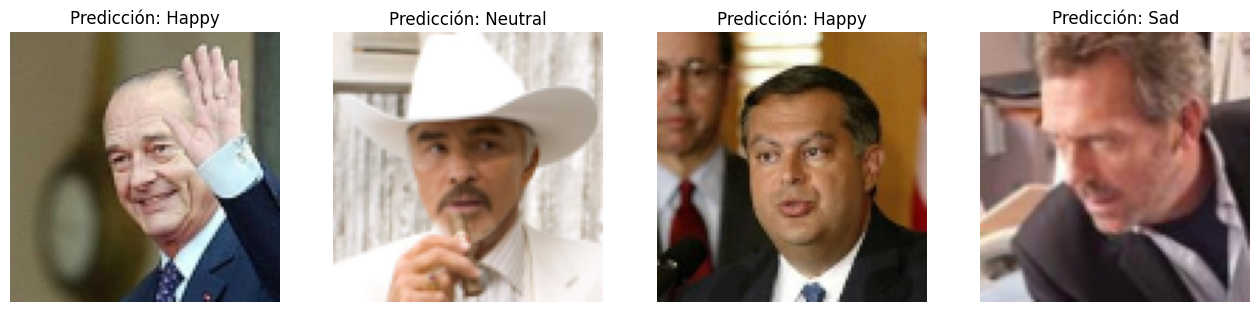

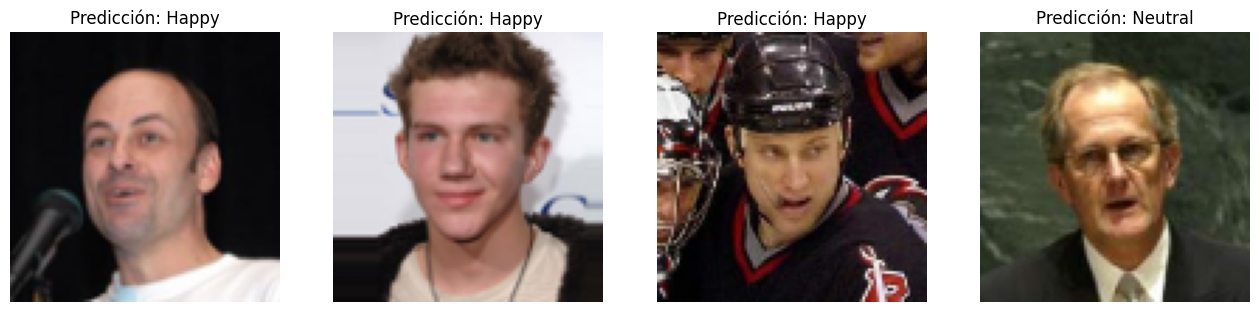

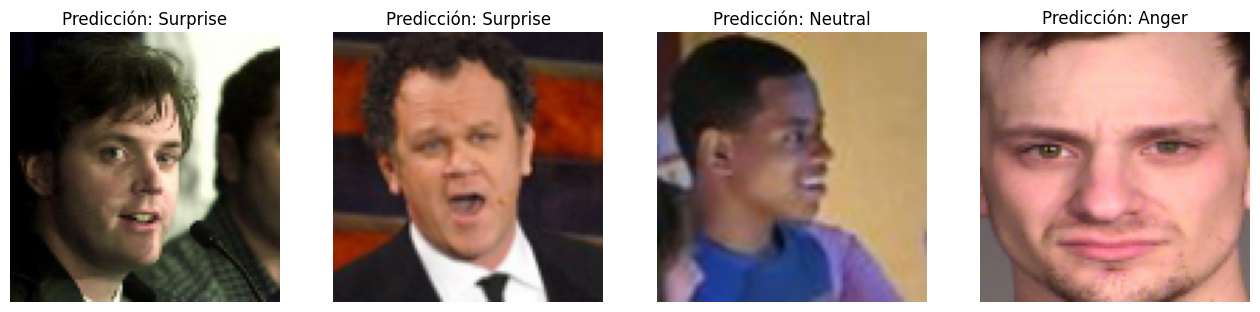

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Predicción: {labels_map.get(str(df['final_prediction'][i]))}")
    ax.axis('off')
    
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i+4])
    ax.set_title(f"Predicción: {labels_map.get(str(df['final_prediction'][i+4]))}")
    ax.axis('off')
    
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i+8])
    ax.set_title(f"Predicción: {labels_map.get(str(df['final_prediction'][i+8]))}")
    ax.axis('off')

Vamos a cargar estas imagenes mediante keras.

In [66]:
df_keras = df.copy()
df_keras["filename"] = df_keras["name"] 
df_keras["class"] = df_keras["final_prediction"].astype(str)  

df_keras = df_keras[["filename", "class"]]

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255) 
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_keras,
    x_col="filename",
    y_col="class",
    target_size=(96, 96),
    class_mode="sparse",  
    batch_size=32,
    shuffle=False  
)

Found 27167 validated image filenames belonging to 5 classes.


Vamos a comprobar si el modelo que teníamos es compatible con este conjunto de datos. Para ello vamos a emplearlo para hacer test.

In [78]:
model_test = tf.keras.models.load_model("model_3.keras")

test_loss, test_acc = model_test.evaluate(val_generator)
print(f"\n🔹 Precisión en test: {test_acc:.2%}")

849/849 ━━━━━━━━━━━━━━━━━━━━ 151s 174ms/step - accuracy: 0.5611 - loss: 2.0677

🔹 Precisión en test: 55.46%


Podemos ver como, efectivamente, partiendo de un conjunto que no estaba etiquetado para este fin hemos logrado interrelacionarlo con el modelo anterior para poder evaluarlo.